In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import ase
import ase.io as aio
import qml
import time
import gc
import scipy as sp
from sklearn.linear_model import LinearRegression
# from qml.kernels import gaussian_kernel
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import ase.calculators.dftb as adftb
from qml.kernels import gaussian_kernel
from qml.kernels import laplacian_kernel
from qml.math import cho_solve
from metric_learn import MLKR
from sklearn.datasets import load_iris
import metric_learn
import copy
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib notebook

In [38]:
# data = np.load('./data/data.npy', allow_pickle=True, dtype=)

In [39]:
data = pd.read_pickle('./data/data')

In [40]:
data['SLATM_P_R'] = [x - y for x,y in zip(data.SLATM_prod.values, data.SLATM_react.values)]


In [41]:
data['bmol'] = [x[:-1] for x in data.mol.values]

In [42]:
extrapolation_data = pd.read_pickle('./extrapolation_data')

In [58]:
extrapolation_data.head()

,mol,int2,int3,TS,ase2,ase3,slatm2,slatm3,slatm_diff
0,Cat7f_R_bp1,-4243.425544,-4243.431732,-4243.412254,"(Atom('O', [3.047659, 0.110227, 0.061362], ind...","(Atom('O', [3.004482, 0.35569, 0.096619], inde...","[45.0, 276.0, 14.0, 24.0, 0.0, 14.0, 34.0, 9.2...","[45.0, 276.0, 14.0, 24.0, 0.0, 14.0, 34.0, 1.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.88397103..."
1,Cat7f_R_bp2,-4243.424933,-4243.443641,-4243.415270,"(Atom('O', [2.139297, 0.714986, -0.08565], ind...","(Atom('O', [2.143934, 1.327725, -0.316844], in...","[45.0, 276.0, 14.0, 24.0, 0.0, 14.0, 34.0, 9.3...","[45.0, 276.0, 14.0, 24.0, 0.0, 14.0, 34.0, 1.3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.32419715..."
2,Cat7f_R_bp3,-4243.412295,-4243.438326,-4243.402189,"(Atom('Si', [-1.46472, 0.552182, -1.477146], i...","(Atom('O', [-2.485908, -0.440976, -0.464488], ...","[45.0, 276.0, 14.0, 24.0, 0.0, 14.0, 34.0, 8.1...","[45.0, 276.0, 14.0, 24.0, 0.0, 14.0, 34.0, 1.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.59694168..."
3,Cat7f_R_bp4,-4243.415841,-4243.438487,-4243.397104,"(Atom('O', [3.17927, 0.846124, -0.580834], ind...","(Atom('O', [2.405124, 1.104057, -0.006423], in...","[45.0, 276.0, 14.0, 24.0, 0.0, 14.0, 34.0, 8.4...","[45.0, 276.0, 14.0, 24.0, 0.0, 14.0, 34.0, 2.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.41291819..."
4,Cat7f_R_bp5,-4243.423559,-4243.445053,-4243.408153,"(Atom('O', [2.982988, 0.768864, 0.307224], ind...","(Atom('O', [-2.310634, -0.312095, 0.573692], i...","[45.0, 276.0, 14.0, 24.0, 0.0, 14.0, 34.0, 7.2...","[45.0, 276.0, 14.0, 24.0, 0.0, 14.0, 34.0, 1.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.98426865..."


In [43]:
mbtypes = np.load('./mbtypes.npy', allow_pickle=True)

In [9]:
slatm_react = [qml.representations.generate_slatm(coordinates=mol.positions, 
                                                 nuclear_charges=mol.get_atomic_numbers(), 
                                                mbtypes=mbtypes, local=False) for mol in extrapolation_data.ase2]

In [10]:
slatm_prod = [qml.representations.generate_slatm(coordinates=mol.positions, 
                                                 nuclear_charges=mol.get_atomic_numbers(), 
                                                mbtypes=mbtypes, local=False) for mol in extrapolation_data.ase3]

In [44]:
extrapolation_data['slatm2'] = slatm_react

In [45]:
extrapolation_data['slatm3'] = slatm_prod

In [46]:
extrapolation_data['slatm_diff'] = [x - y for x,y in zip(slatm_prod, slatm_react)]

In [47]:
extrapolation_data.to_pickle('extrapolation_data')

In [48]:
Y = data.Eafw.values

# Extrapolation SLATM_DIFF+

In [50]:
slatmdiff = np.vstack(data.SLATM_P_R.values)

In [51]:
lin_regs = [sp.stats.linregress(xs, ys) for xs, ys in zip(slatmdiff.T, 
                                                     [Y for i in range(
                                                         slatmdiff.shape[1])])]   
rvalues = np.array([ccc.rvalue for ccc in lin_regs])

In [52]:
pre = sk.preprocessing.MinMaxScaler()
pre.fit(slatmdiff[:, np.argsort(rvalues**2)[-500:]])
Xf =  pre.transform(slatmdiff[:, np.argsort(rvalues**2)[-500:]])

dmtrtr = sk.metrics.pairwise.pairwise_distances(Xf, n_jobs=-1)

sigma = 6

regg = 1e-6

K = np.exp(- 0.5 * sigma ** -2 * dmtrtr ** 2)
K[np.diag_indices_from(K)] += regg
alpha_vec = cho_solve(K, Y)

In [53]:
X_extrapolation = pre.transform(
            np.vstack(extrapolation_data.slatm_diff.values)[:, np.argsort(rvalues**2)[-500:]])
    
dmtrts = sk.metrics.pairwise.pairwise_distances(X_extrapolation, Xf, n_jobs=-1)

# extrapolation

Ks = np.exp(- 0.5 * sigma ** -2 * dmtrts ** 2)

Y_predicted = np.dot(Ks, alpha_vec)

<IPython.core.display.Javascript object>


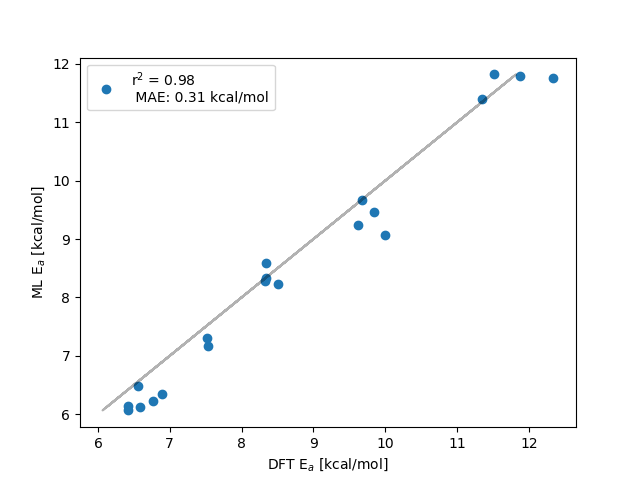

In [55]:
fig, ax = plt.subplots()

exact = 627.509 * (extrapolation_data.TS - extrapolation_data.int2).values
ax.scatter(Y_predicted, exact, 
          label='r$^2$ = {:.2f} \n MAE: {:.2f} kcal/mol'.format(
              np.corrcoef(Y_predicted, exact)[0][1] ** 2,
              np.mean(np.abs(Y_predicted - exact)))
          )

ax.plot(exact, exact, color='black', alpha=0.3)
ax.legend()
ax.set_xlabel('DFT E$_a$ [kcal/mol]')
ax.set_ylabel('ML E$_a$ [kcal/mol]')
plt.show()